In [1]:
# Import libraries

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, Lambda
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import cv2
# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

2024-05-12 06:46:00.633467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 06:46:00.633645: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 06:46:00.773024: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load train and test datasets from CSV files
train_dataset = pd.read_csv('C:/Users/intra/snn_verification/sign_data/train_data.csv', header = None)
test_dataset = pd.read_csv('C:/Users/intra/snn_verification/sign_data/test_data.csv', header = None) 

# Define directories for train and test data
train_dir = "C:/Users/intra/snn_verification/sign_data/test"
test_dir = "C:/Users/intra/snn_verification/sign_data/test"

In [3]:
class DataLoader:
    def __init__(self, dataset, batch_size, dir):
        self.dataset = dataset
        self.batch_size = batch_size
        self.dir = dir
    
    def shuffle(self):
        # Shuffling the dataset
        return self.dataset.sample(frac=1)
    
    def preprocess_image(self, img_path):
        # Read image file
        img = tf.io.read_file(img_path)
        # Decode image and convert to grayscale
        img = tf.image.decode_png(img, channels=1) 
        # Resize image to desired dimensions
        img = tf.image.resize(img, (128, 128))
        # Convert image data type to uint8
        img = tf.cast(img, tf.uint8) 

        # Apply Canny edge detection using OpenCV
        img_cv2 = cv2.Canny(img.numpy(), 20, 220) 
        
        # Normalize pixel values to [0, 1]
        img_cv2 = tf.cast(img_cv2, tf.float32) / 255.0
        
        return img_cv2
    
    def datagen(self):
        num_samples = len(self.dataset)
        while True:
            # Shuffle dataset for each epoch
            self.dataset = self.shuffle()
            for batch in range(0, num_samples, self.batch_size):
                # Get batch samples
                image1_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 0]]
                image2_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 1]]
                label_batch_samples = self.dataset.iloc[batch:batch + self.batch_size, 2]
                Image1, Image2, Label = [], [], []
                for image1, image2, label in zip(image1_batch_samples, image2_batch_samples, label_batch_samples):
                    # Preprocess image1
                    image1_data = self.preprocess_image(image1)
                    # Preprocess image2
                    image2_data = self.preprocess_image(image2)
                    # Append preprocessed images and labels to lists
                    Image1.append(image1_data)
                    Image2.append(image2_data)
                    Label.append(label)

                # Convert lists to numpy arrays
                Image1 = np.asarray(Image1)
                Image2 = np.asarray(Image2)
                Label = np.asarray(Label)
                # Yield batch data
                yield {"image1": Image1, "image2": Image2}, Label


In [4]:
train_set, val_set = train_test_split(train_dataset, test_size=0.25)

# Create train, val and test 
train_gen = DataLoader(train_set, 256, train_dir)
val_gen = DataLoader(val_set, 256, train_dir)
test_gen = DataLoader(test_dataset, 256, test_dir)  

Pair 1:
Label: 0


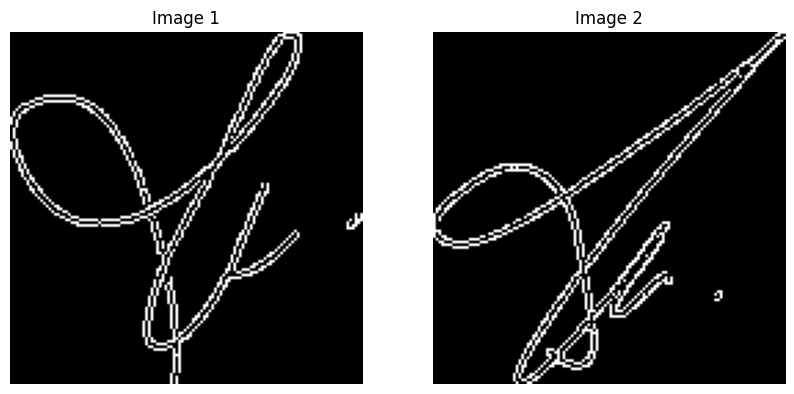

Pair 2:
Label: 0


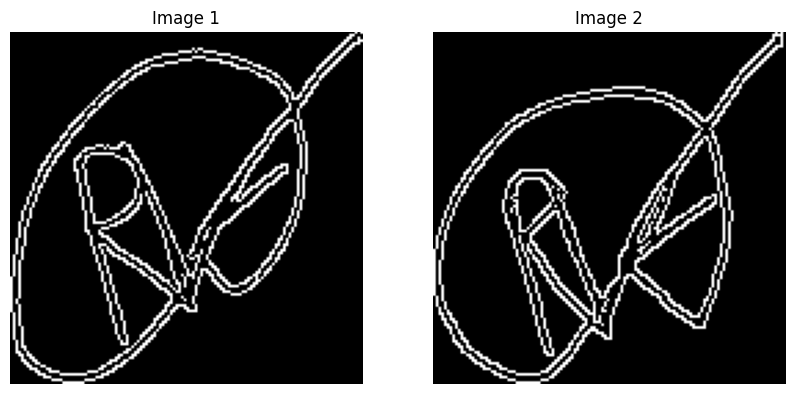

Pair 3:
Label: 0


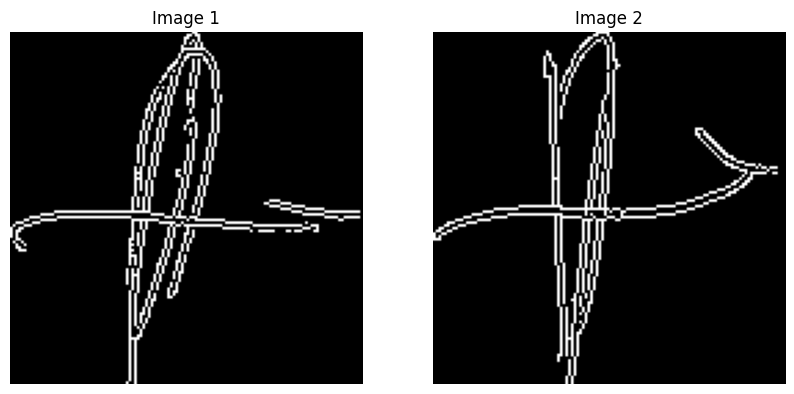

Pair 4:
Label: 1


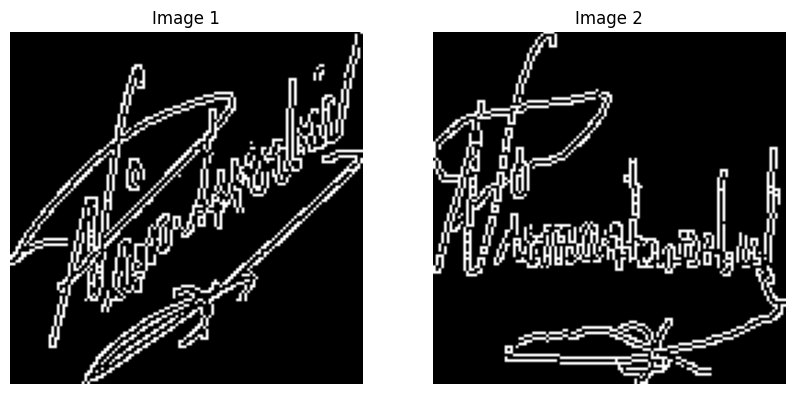

Pair 5:
Label: 0


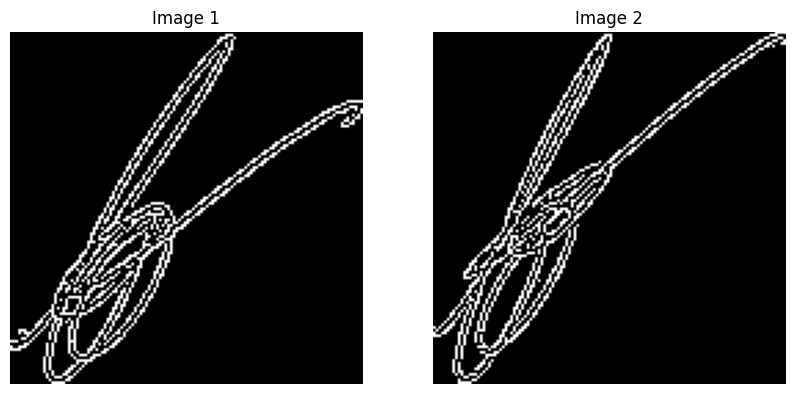

In [5]:

# Create data generator
generator = train_gen.datagen()

# Plot 5 1st images in batch
for i in range(5):
    batch_data, label = next(generator)
    
    pair_data = batch_data["image1"], batch_data["image2"]
    
    print(f"Pair {i+1}:")
    print("Label:", label[0]) 
    
    plt.figure(figsize=(10, 5))
    for j in range(2):
        plt.subplot(1, 2, j+1)
        plt.imshow(pair_data[j][0], cmap='gray')
        plt.title('Image {}'.format(j+1))
        plt.axis('off')
    
    plt.show()


In [6]:
def create_siamese_model(input_shape):
    # Define the base convolutional neural network (CNN) model
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dense(128, activation='relu'))
    
    # Define inputs for the siamese network
    input1 = Input(input_shape, name="image1")
    input2 = Input(input_shape, name="image2")

    # Obtain embeddings for both inputs using the base CNN model
    embedding1 = model(input1)
    embedding2 = model(input2)

    # Define a lambda layer to calculate the Manhattan distance between embeddings
    manhattan_distance_layer = Lambda(lambda tensors: tf.abs(tensors[0] - tensors[1]))

    # Calculate the Manhattan distance between embeddings
    manhattan_distance = manhattan_distance_layer([embedding1, embedding2])

    # Define the final output layer to predict similarity (0 for dissimilar, 1 for similar)
    output = Dense(1, activation='sigmoid')(manhattan_distance)

    # Create the siamese model with inputs and output
    siamese_model = Model(inputs=[input1, input2], outputs=output)

    return siamese_model


In [7]:
# Define the shape of input images: height 128 pixels, width 128 pixels, and 1 channel (grayscale)
input_shape = (128, 128, 1)

In [8]:
# Create the siamese model using the specified input shape
model = create_siamese_model(input_shape)

# Print a summary of the siamese model architecture
model.summary()

# Compile the siamese model with binary cross-entropy loss, Adam optimizer, and accuracy metric
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image1 (InputLayer) │ (None, 128, 128,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image2 (InputLayer) │ (None, 128, 128,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128)       │  2,522,624 │ image1[0][0],     │
│ (Sequential)        │                   │            │ image2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ sequential[0][0], │
│                     │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,522,753 (9.62 MB)

 Trainable params: 2,522,753 (9.62 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Define callbacks
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

callbacks_list = [checkpoint, early_stopping]

In [10]:
# Model training
history = model.fit(x=train_gen.datagen(),
                            steps_per_epoch=len(train_set) // 256,
                            epochs=100,
                            validation_data=val_gen.datagen(),
                            validation_steps=len(val_set) // 256,
                            callbacks=callbacks_list)

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5887 - loss: 0.6602
Epoch 1: val_accuracy improved from -inf to 0.67738, saving model to best_model.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 521s 8s/step - accuracy: 0.5894 - loss: 0.6597 - val_accuracy: 0.6774 - val_loss: 0.5955
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7340 - loss: 0.5271
Epoch 2: val_accuracy improved from 0.67738 to 0.83339, saving model to best_model.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 511s 8s/step - accuracy: 0.7344 - loss: 0.5266 - val_accuracy: 0.8334 - val_loss: 0.4129
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8425 - loss: 0.3570
Epoch 3: val_accuracy improved from 0.83339 to 0.92427, saving model to best_model.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 495s 7s/step - accuracy: 0.8427 - loss: 0.3566 - val_accuracy: 0.9243 - val_loss: 0.2292
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9139 - loss: 0.2206
Epoch 4: val_accuracy improved from 0.92427 to 0.964

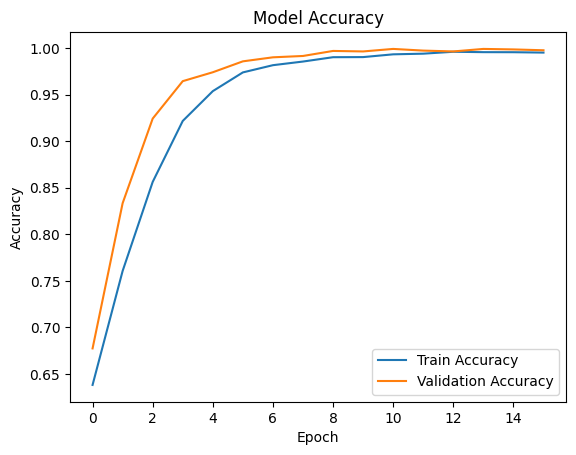

In [11]:
# Train and validation model accuracy for every epoch

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

In [12]:
# load weights

model.load_weights("best_model.keras")

In [13]:
mytest_dir = "C:/Users/intra/snn_verification/sign_data/test"
mytest_dataset = pd.read_csv('C:/Users/intra/snn_verification/sign_data/test_data.csv', header = None)

In [14]:
# Testing model on test dataset

test_loss, test_accuracy = model.evaluate(test_gen.datagen(),
                                          steps=len(test_dataset) // 256)

22/22 ━━━━━━━━━━━━━━━━━━━━ 86s 4s/step - accuracy: 0.9990 - loss: 0.0040


In [15]:
# Getting image pairs and their labels for the test dataset
test_pairs, test_labels = next(test_gen.datagen())

In [16]:
# Getting predictions for the test dataset
test_predictions = model.predict(test_pairs)

# Conversion of predictions to binary format (0 or 1)
binary_predictions = (test_predictions > 0.5).astype(int)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step


Pair 236
True Label: 1
Predicted Label: [1]


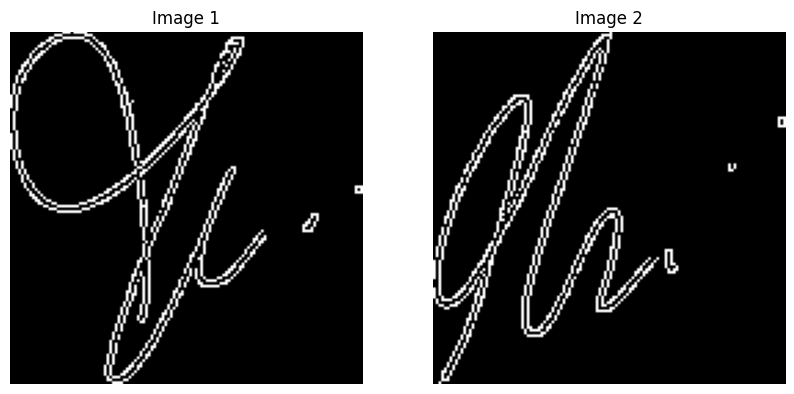

Pair 27
True Label: 0
Predicted Label: [0]


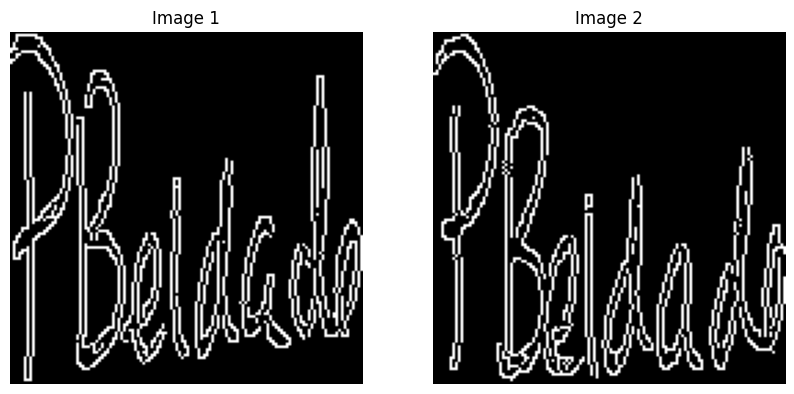

Pair 195
True Label: 1
Predicted Label: [1]


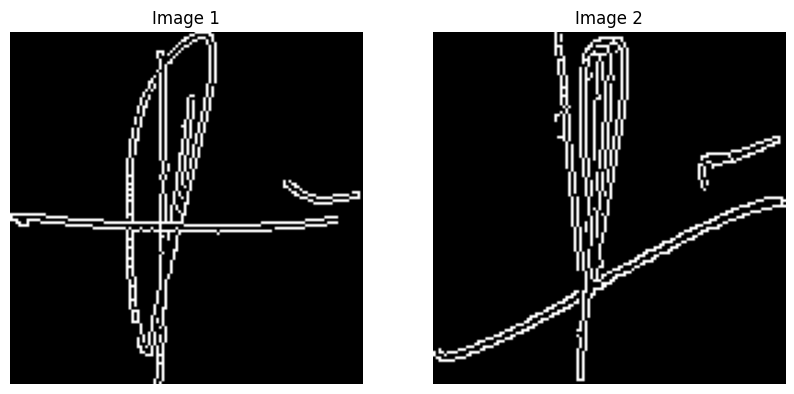

Pair 220
True Label: 1
Predicted Label: [1]


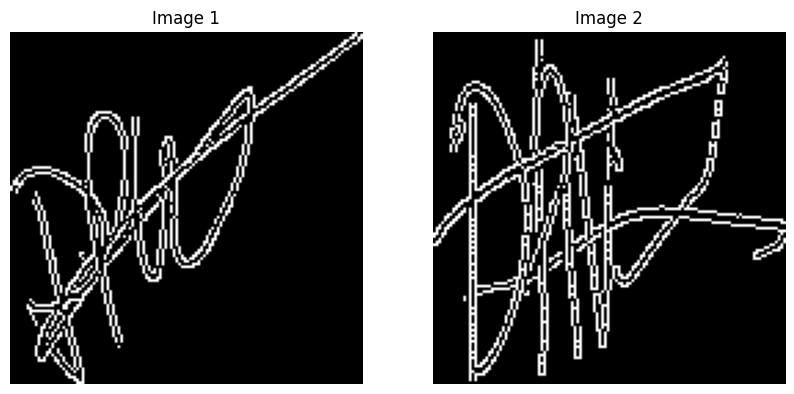

Pair 77
True Label: 0
Predicted Label: [0]


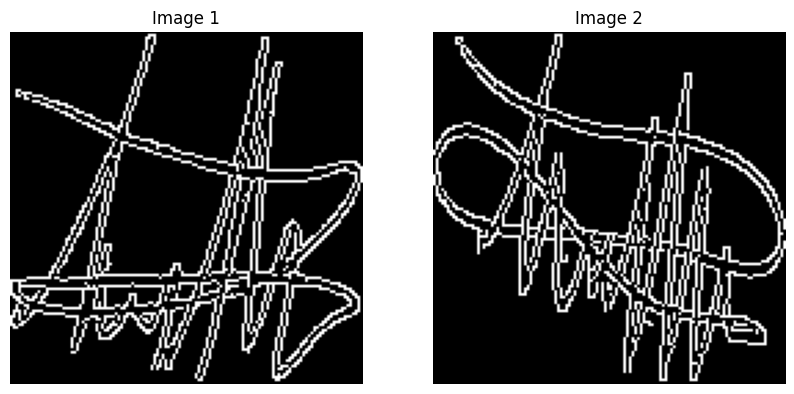

Pair 218
True Label: 1
Predicted Label: [1]


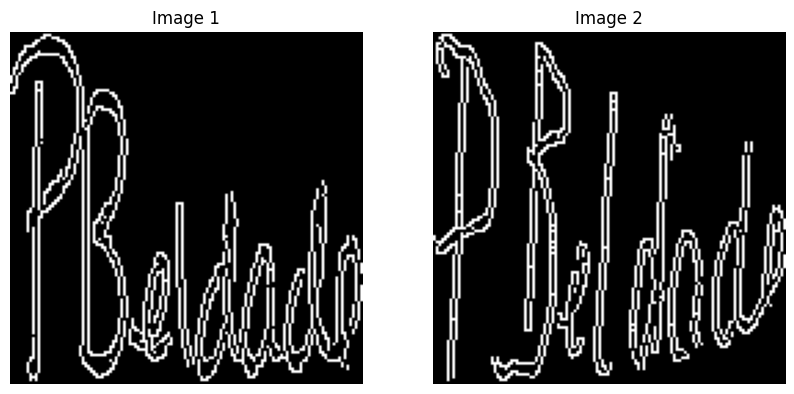

Pair 176
True Label: 1
Predicted Label: [1]


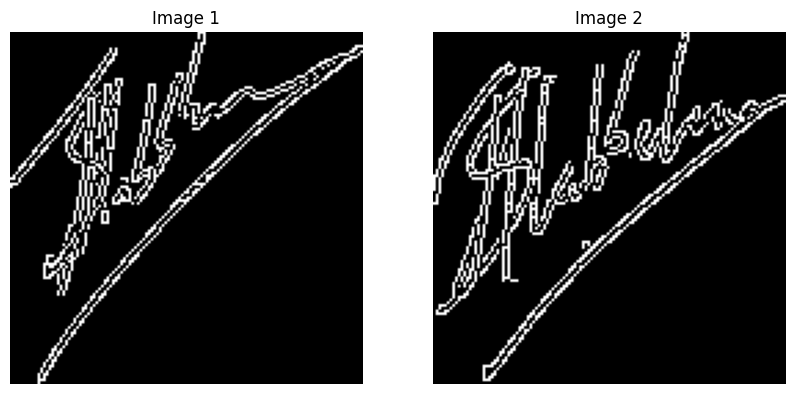

Pair 82
True Label: 1
Predicted Label: [1]


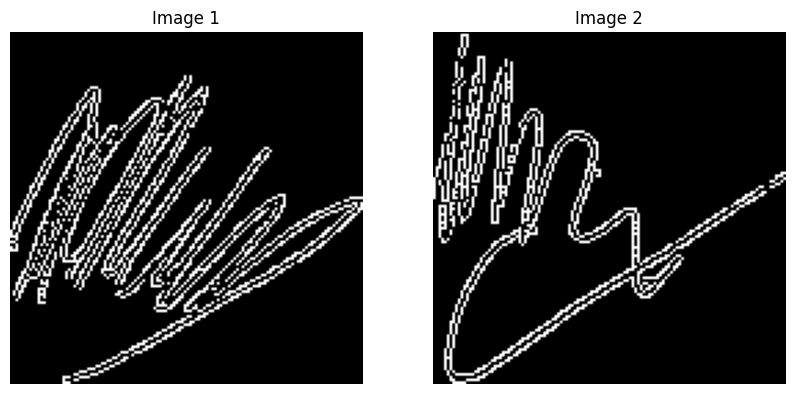

Pair 51
True Label: 1
Predicted Label: [1]


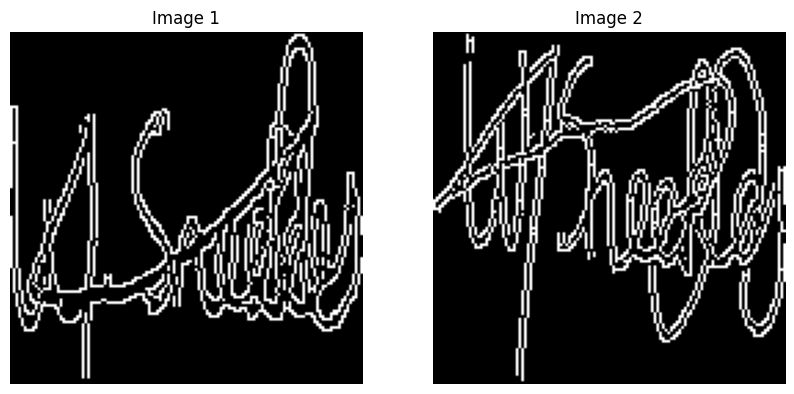

Pair 69
True Label: 1
Predicted Label: [1]


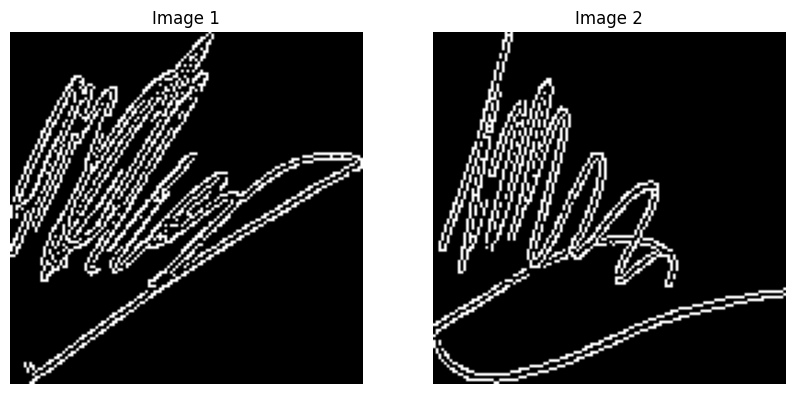

Pair 65
True Label: 1
Predicted Label: [1]


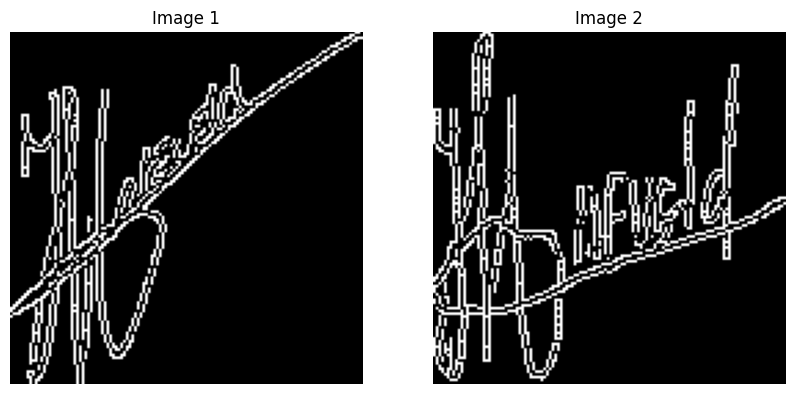

Pair 31
True Label: 1
Predicted Label: [1]


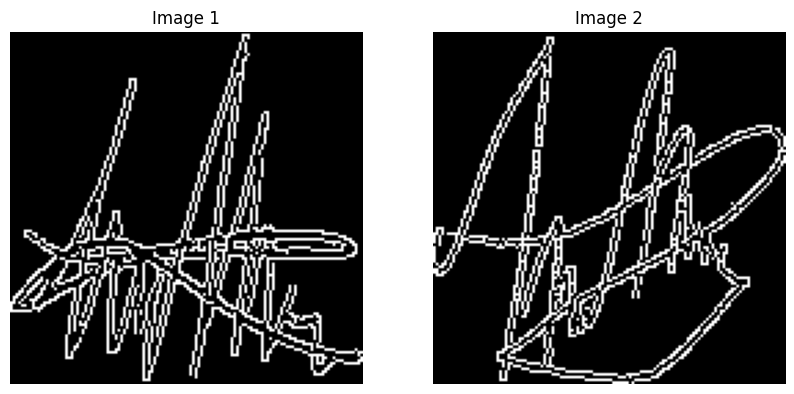

Pair 121
True Label: 0
Predicted Label: [0]


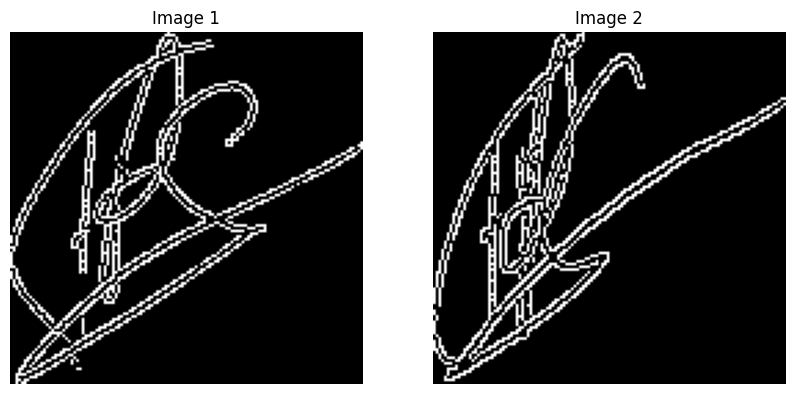

Pair 92
True Label: 1
Predicted Label: [1]


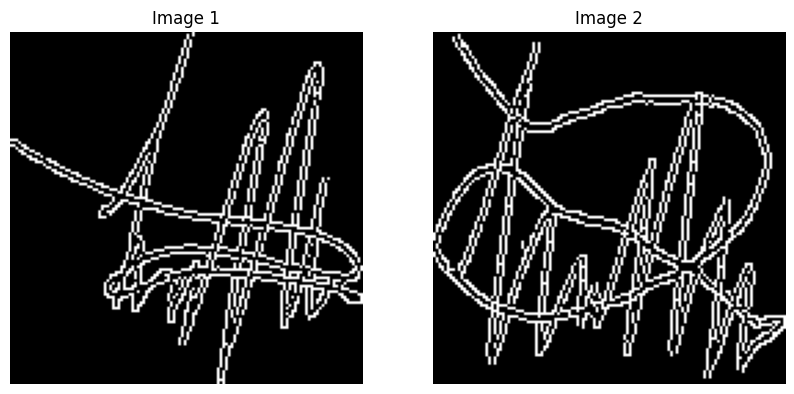

Pair 55
True Label: 1
Predicted Label: [1]


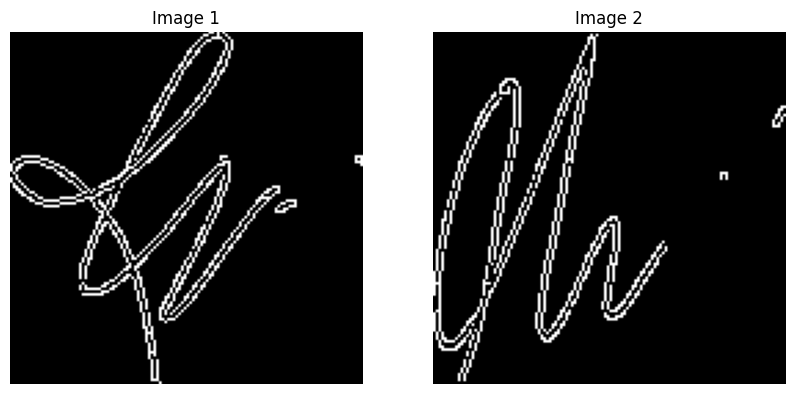

Pair 100
True Label: 1
Predicted Label: [1]


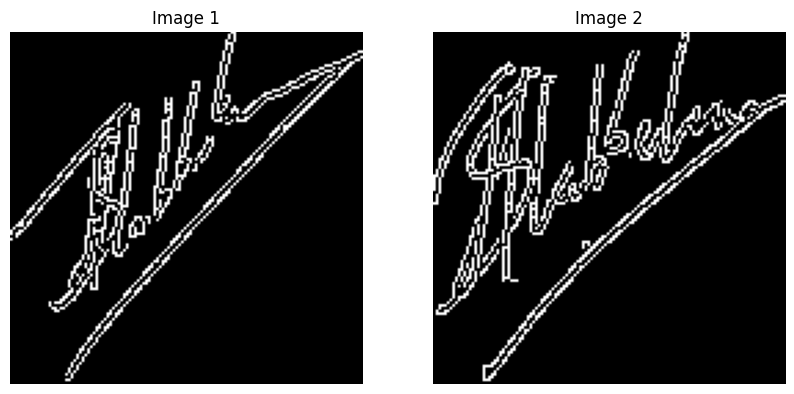

Pair 215
True Label: 0
Predicted Label: [0]


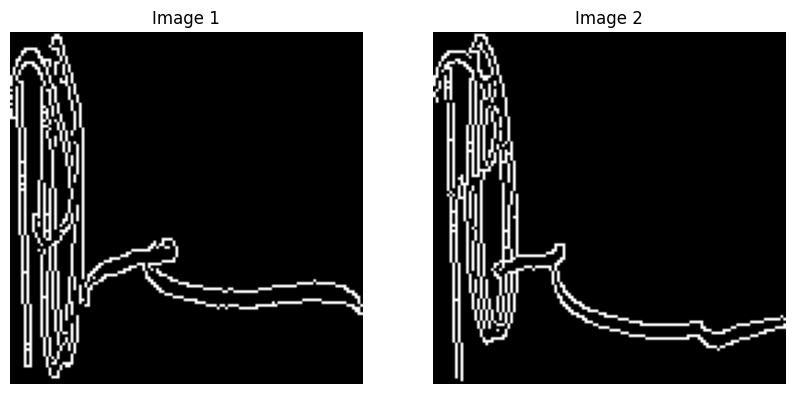

Pair 242
True Label: 1
Predicted Label: [1]


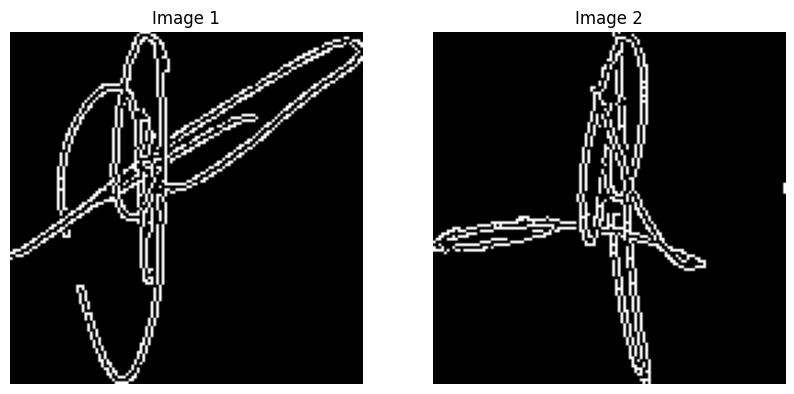

Pair 13
True Label: 0
Predicted Label: [0]


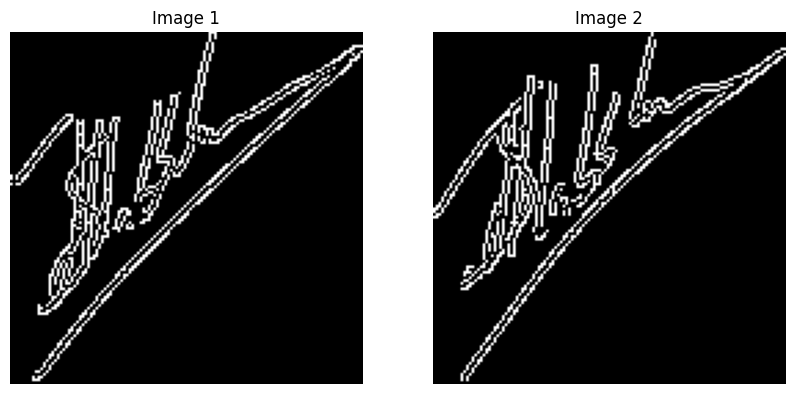

Pair 56
True Label: 1
Predicted Label: [1]


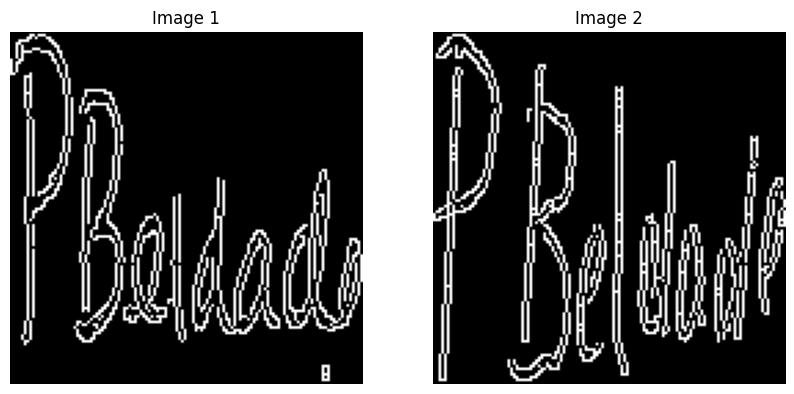

In [17]:
import random

# Getting random 20 pair indices for output
random_indices = random.sample(range(len(test_pairs['image1'])), 20)

# Output random 20 pairs of images, their true labels and predicted labels
for i in random_indices:
    
    image1 = test_pairs['image1'][i]
    image2 = test_pairs['image2'][i]
    
    # Getting the true label and predicted label
    true_label = test_labels[i]
    predicted_label = binary_predictions[i]
    
    # output
    print("Pair", i+1)
    print("True Label:", true_label)
    print("Predicted Label:", predicted_label)
    
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image1.squeeze(), cmap='gray')
    plt.title('Image 1')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image2.squeeze(), cmap='gray')
    plt.title('Image 2')
    plt.axis('off')
    
    plt.show()

In [18]:

# Loading the best model
model.load_weights("best_model.keras")

In [19]:
# Define the directory containing test data
mytest_dir = "C:/Users/intra/snn_verification/sign_data/test"

# Load test dataset from a CSV file

mytest_dataset = pd.read_csv('C:/Users/intra/snn_verification/sign_data/test_data.csv', encoding='latin1', header=None)


In [20]:
class CDataLoader:
    def __init__(self, dataset, batch_size, dir):
        # Initialize the DataLoader with dataset, batch_size, and directory
        self.dataset = dataset
        self.batch_size = batch_size
        self.dir = dir
    
    def shuffle(self):
        # Shuffle the dataset
        return self.dataset.sample(frac=1)
    
    def preprocess_image(self, img_path):
        # Read image file
        img = tf.io.read_file(img_path)
        # Decode image (assuming JPEG format) and convert to grayscale
        img = tf.image.decode_jpeg(img, channels=1) 
        # Resize image to 128x128 pixels
        img = tf.image.resize(img, (128, 128))
        # Convert image data type to uint8
        img = tf.cast(img, tf.uint8) 

        # Apply Canny edge detection using OpenCV
        img_cv2 = cv2.Canny(img.numpy(), 20, 220) 
        
        # Normalize pixel values to [0, 1]
        img_cv2 = tf.cast(img_cv2, tf.float32) / 255.0
        
        return img_cv2
    
    def datagen(self):
        num_samples = len(self.dataset)
        while True:
            # Shuffle dataset for each epoch
            self.dataset = self.shuffle()
            # Iterate over dataset in batches
            for batch in range(0, num_samples, self.batch_size):
                # Get batch samples
                image1_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 0]]
                image2_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 1]]
                label_batch_samples = self.dataset.iloc[batch:batch + self.batch_size, 2]
                Image1, Image2, Label = [], [], []
                # Preprocess batch samples
                for image1, image2, label in zip(image1_batch_samples, image2_batch_samples, label_batch_samples):
                    image1_data = self.preprocess_image(image1)
                    image2_data = self.preprocess_image(image2)
                    Image1.append(image1_data)
                    Image2.append(image2_data)
                    Label.append(label)
                # Convert lists to numpy arrays
                Image1 = np.asarray(Image1)
                Image2 = np.asarray(Image2)
                Label = np.asarray(Label)
                # Yield batch data
                yield {"image1": Image1, "image2": Image2}, Label


In [21]:
#CDataLoader object for generating batches of test data
mytestgen = CDataLoader(mytest_dataset, 2, mytest_dir)


In [22]:
# Generate a data generator from the CDataLoader object for obtaining batches of test data
generator = mytestgen.datagen()

# Get the next batch of data and corresponding labels from the generator
batch_data, labels = next(generator)


In [23]:
print("Image1 data shape:", batch_data["image1"].shape)
print("Image2 data shape:", batch_data["image2"].shape)
print("Label data shape:", labels.shape)

Image1 data shape: (2, 128, 128)
Image2 data shape: (2, 128, 128)
Label data shape: (2,)


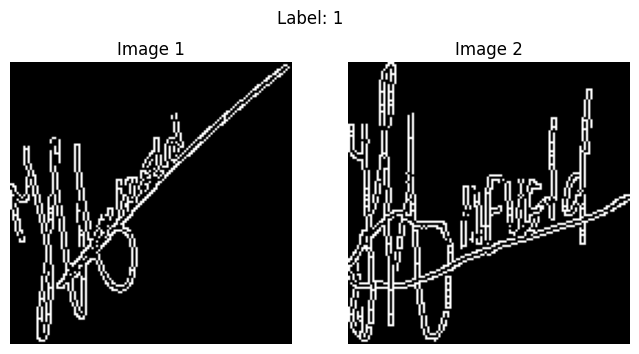

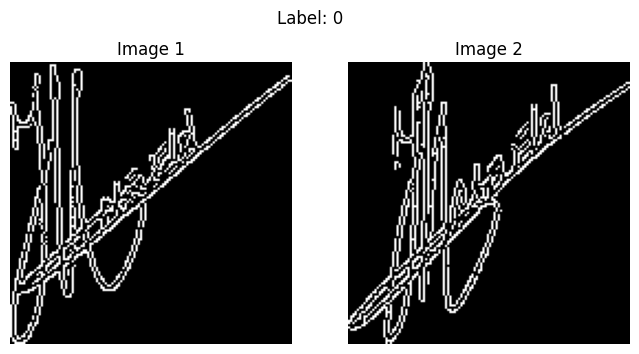

In [24]:
for i in range(len(batch_data["image1"])):
    image1 = batch_data["image1"][i]
    image2 = batch_data["image2"][i]
    label = labels[i]
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image1, cmap='gray')
    plt.title('Image 1')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image2, cmap='gray')
    plt.title('Image 2')
    plt.axis('off')
    
    plt.suptitle('Label: ' + str(label))
    plt.show()

In [25]:
# Evaluate the model using the test data generator
# Steps parameter is set to the number of batches in the test dataset
mytest_loss, mytest_accuracy = model.evaluate(mytestgen.datagen(), steps=len(mytest_dataset) // 2)


2874/2874 ━━━━━━━━━━━━━━━━━━━━ 101s 35ms/step - accuracy: 0.9990 - loss: 0.0042


In [26]:
print("Test Loss:", mytest_loss)
print("Test Accuracy:", mytest_accuracy)


Test Loss: 0.0036176193971186876
Test Accuracy: 0.9993041157722473


In [27]:
# Generate a batch of test data and corresponding labels using the test data generator
test_pairs, test_labels = next(mytestgen.datagen())


In [28]:
# Predict labels for the test data pairs using the trained model
test_predictions = model.predict(test_pairs)

# Convert predicted probabilities to binary predictions using a threshold of 0.5
binary_predictions = (test_predictions > 0.5).astype(int)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


Pair 1
True Label: 1
Predicted Label: [1]


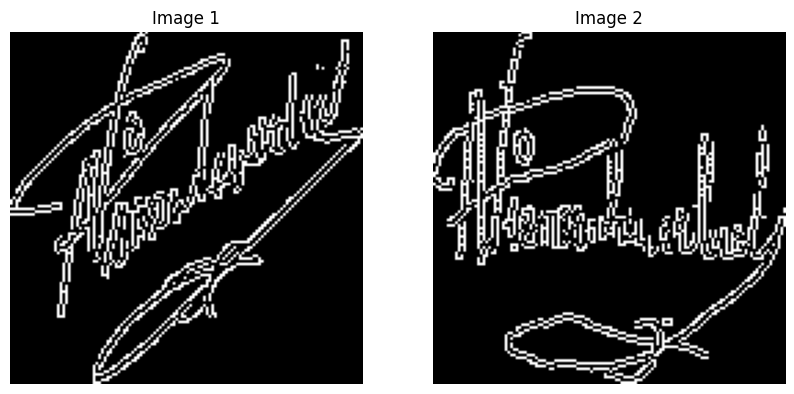

Pair 2
True Label: 0
Predicted Label: [0]


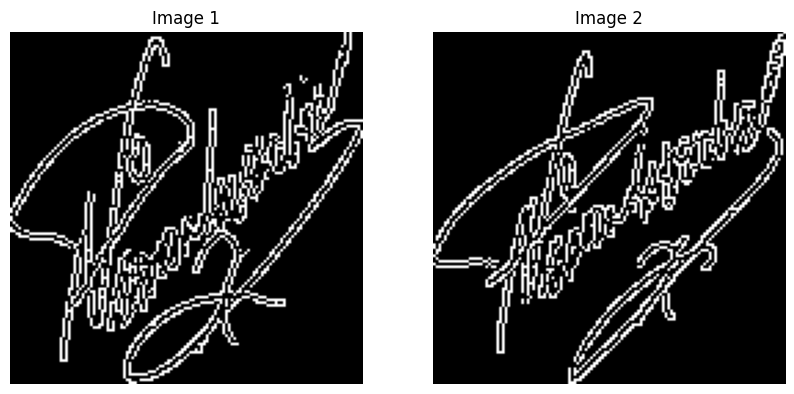

In [29]:
import random

# Generate random indices to select pairs of images
random_indices = random.sample(range(len(test_pairs['image1'])), 2)

# Iterate over random indices to display image pairs
for i in random_indices:
    # Get image pair and corresponding labels
    image1 = test_pairs['image1'][i]
    image2 = test_pairs['image2'][i]
    true_label = test_labels[i]
    predicted_label = binary_predictions[i]
    
    # Print pair information
    print("Pair", i+1)
    print("True Label:", true_label)
    print("Predicted Label:", predicted_label)
    
    # Plot image pair
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image1.squeeze(), cmap='gray')
    plt.title('Image 1')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image2.squeeze(), cmap='gray')
    plt.title('Image 2')
    plt.axis('off')
    
    plt.show()
